# Phase 1 - Exploratory Data Analysis

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (11, 4)
plt.rcParams["axes.grid"] = True

df = pd.read_csv("data.csv")  

# Rename Columns for consistency
rename_map = {
    "DateTime": "datetime",
    "Temperature": "temp",
    "Humidity": "humidity",
    "Wind Speed": "WS",
    "general diffuse flows": "GDF",
    "diffuse flows": "DF",
    "Zone 1 Power Consumption": "PZ1",
    "Zone 2  Power Consumption": "PZ2",
    "Zone 3  Power Consumption": "PZ3"
}
df.rename(columns=rename_map, inplace=True)

# Parse datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.dropna(subset=["datetime"]).sort_values("datetime")
df.head()

,datetime,temp,humidity,WS,GDF,DF,PZ1,PZ2,PZ3
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [2]:
for col in df.columns:
    print(col, {df[col].dtype})

datetime {dtype('<M8[ns]')}
temp {dtype('float64')}
humidity {dtype('float64')}
WS {dtype('float64')}
GDF {dtype('float64')}
DF {dtype('float64')}
PZ1 {dtype('float64')}
PZ2 {dtype('float64')}
PZ3 {dtype('float64')}


'<M8[ns]' actually means datetime64[ms], so 'datetime' is stored as high-precision timestamps (with a nanosecond resolution)

## Checking frequency and consistency

In [3]:
# === 1) Check frequency & consistency without setting index permanently ===
deltas = df["datetime"].diff().dropna()
inferred = pd.infer_freq(df["datetime"])
print(f"Inferred frequency: {inferred}")
print(f"Number of observations: {len(df)}, \n")

if not deltas.empty:
    modal_delta = deltas.mode().iloc[0]
    full_range = pd.date_range(df["datetime"].min(), df["datetime"].max(), freq=modal_delta)
    missing = full_range.difference(df["datetime"])
    print(f"Modal step: {modal_delta}")
    print(f"Missing timestamps: {len(missing)}")

Inferred frequency: 10min
Number of observations: 52416, 

Modal step: 0 days 00:10:00
Missing timestamps: 0


No missing timestamps, data recorded every 10 minutes.

## Visualizing Power Consumption Trends

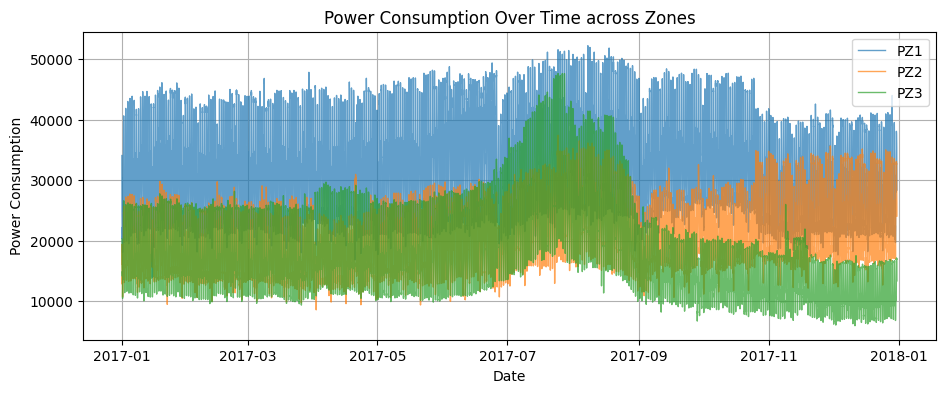

In [4]:
zone_cols = ["PZ1", "PZ2", "PZ3"]

plt.figure()
for z in zone_cols:
    plt.plot(df["datetime"], df[z], label=z, linewidth=1, alpha=0.7)
plt.title("Power Consumption Over Time across Zones")
plt.xlabel("Date")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

Can also normalize values using this plot command:

plt.plot(df["datetime"], df[z] / df[z].max(), label=z, linewidth=1, alpha=0.7)

### Power Consumption for each Individual Zone

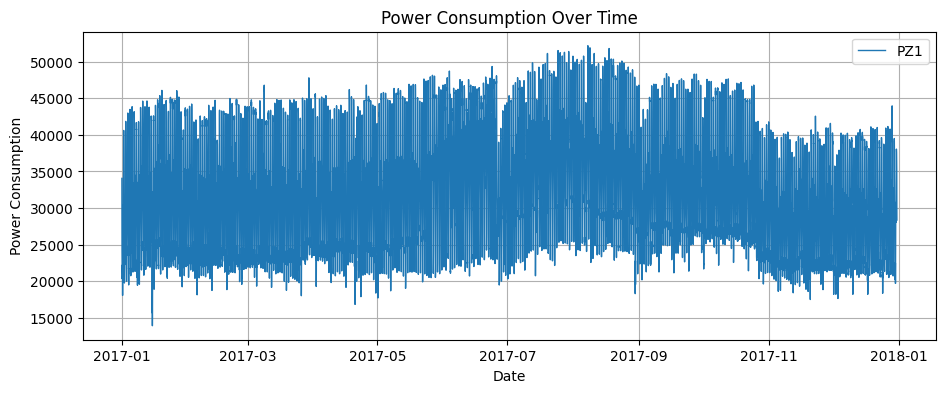

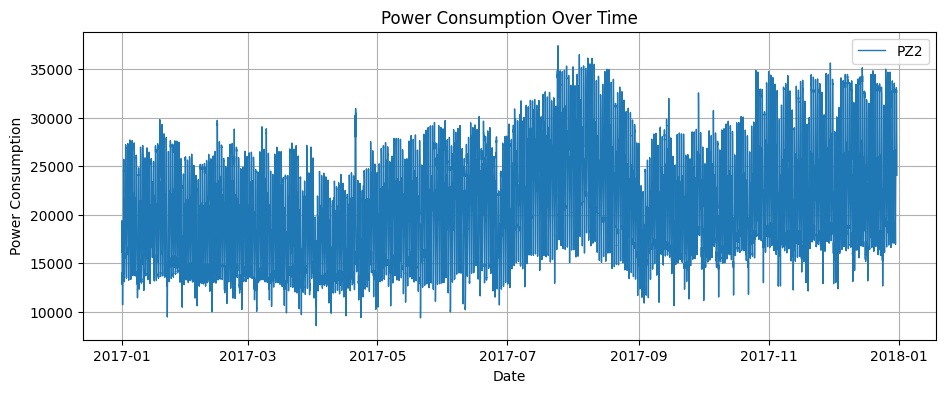

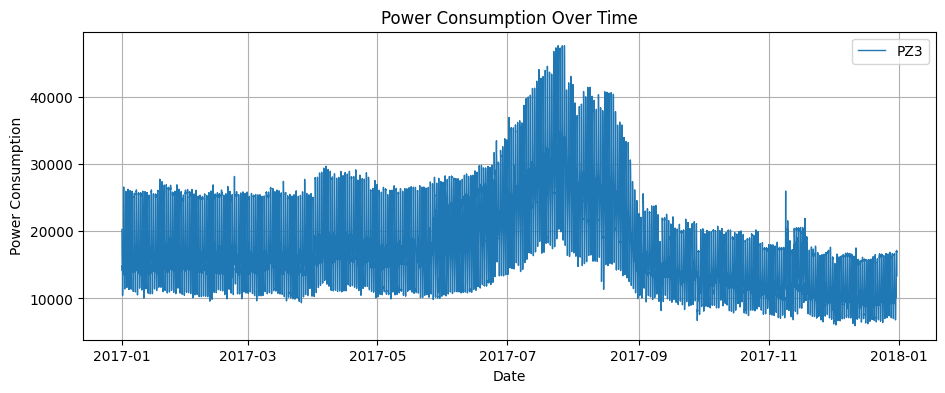

In [5]:
plt.figure()
for z in zone_cols:
    plt.plot(df["datetime"], df[z], label=z, linewidth=1)
    plt.title("Power Consumption Over Time")
    plt.xlabel("Date")
    plt.ylabel("Power Consumption")
    plt.legend()
    plt.show()

- Zone 1 appears to have the highest power consumption, with consistent variation all year round.
- Zones 2 and 3 have lower average power consumption all year round, although less variability than Zone 1. Zone 3 power consumption experiences a very sharp spike in the summer months (from June to August)

### Daily Means

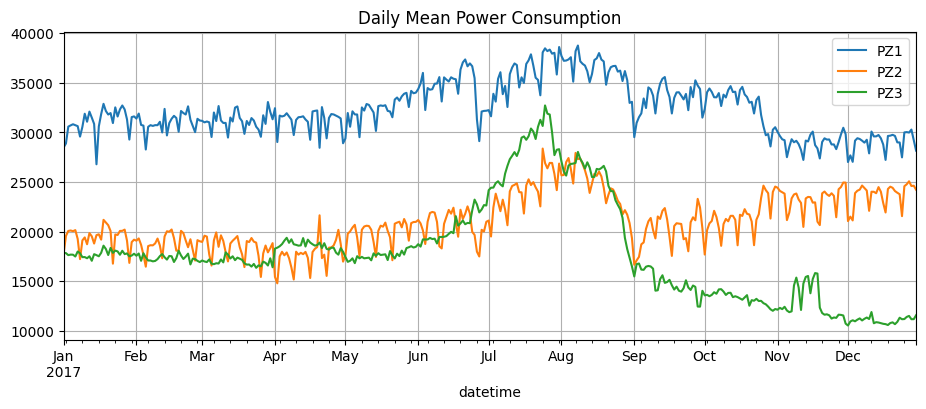

In [6]:
# Daily mean (temporary index for resample)
df.set_index("datetime")[zone_cols].resample("D").mean().plot(
    title="Daily Mean Power Consumption", linewidth=1.5
)
plt.show()

Perhaps a day-time and night-time mean should be created to get a more accurate measure of power consumption? Rather than 'daily means'

## Comparing with Environmental Features

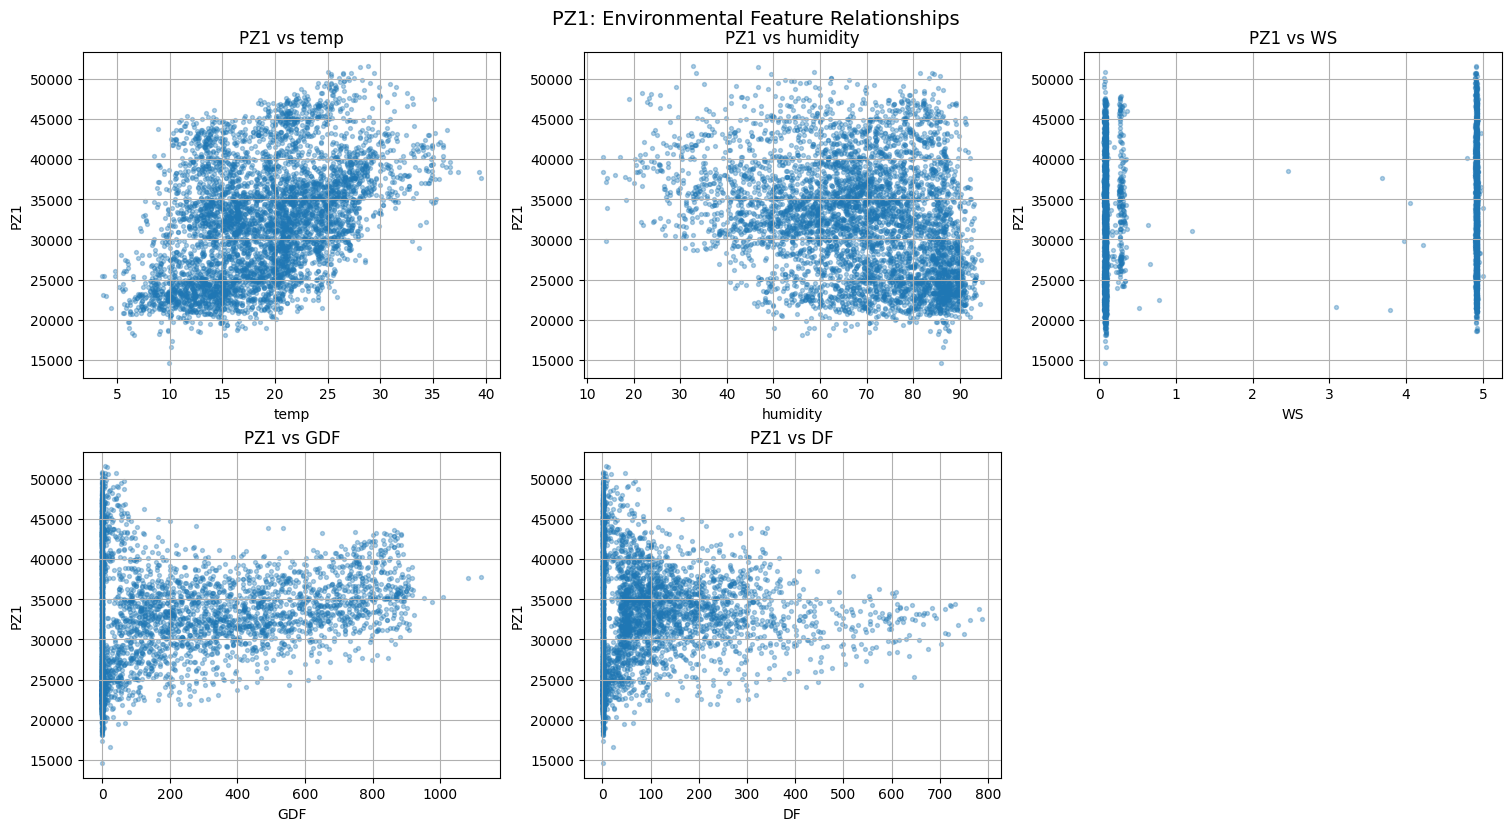

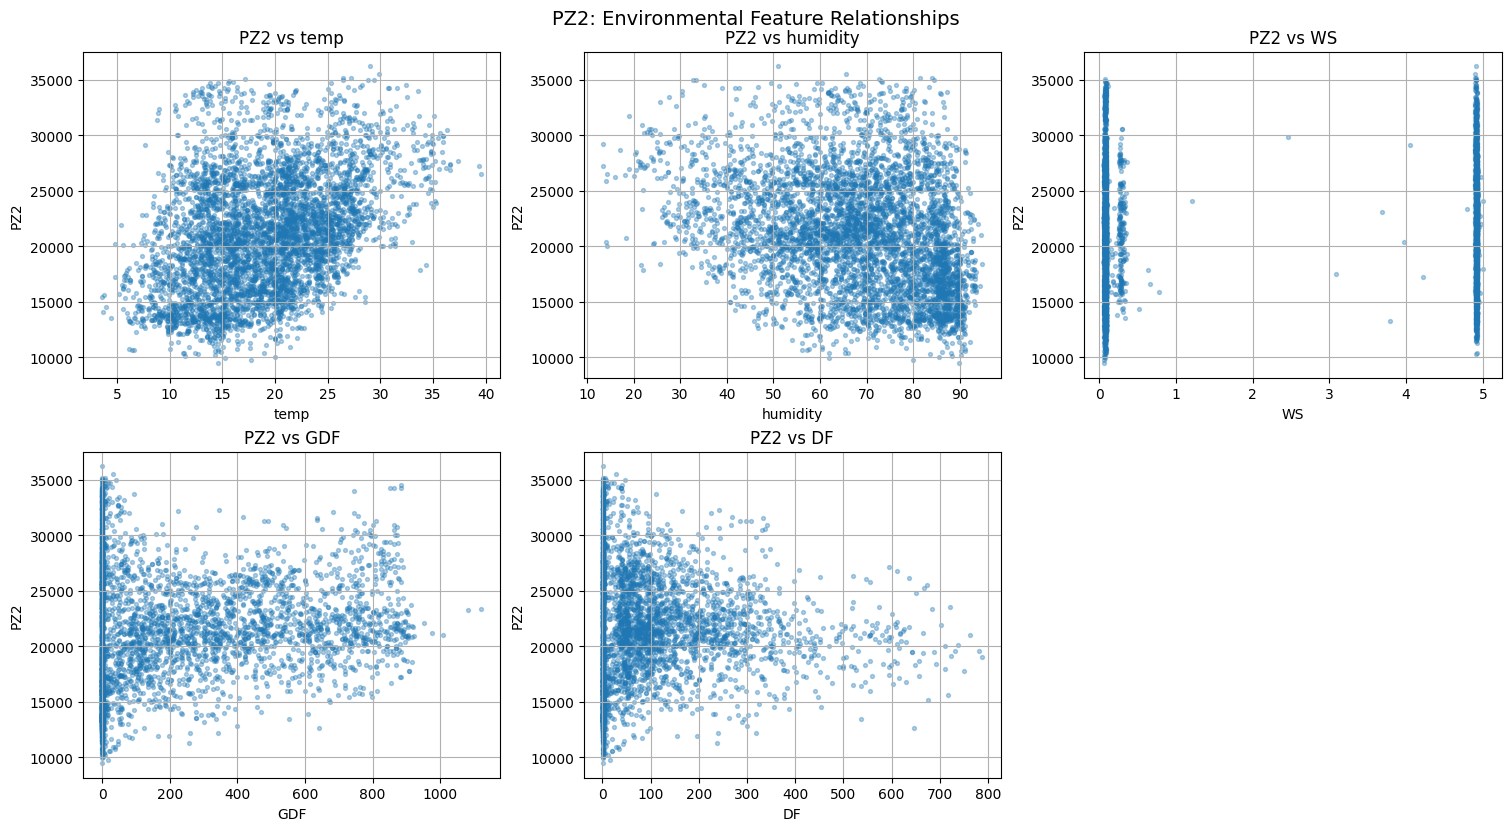

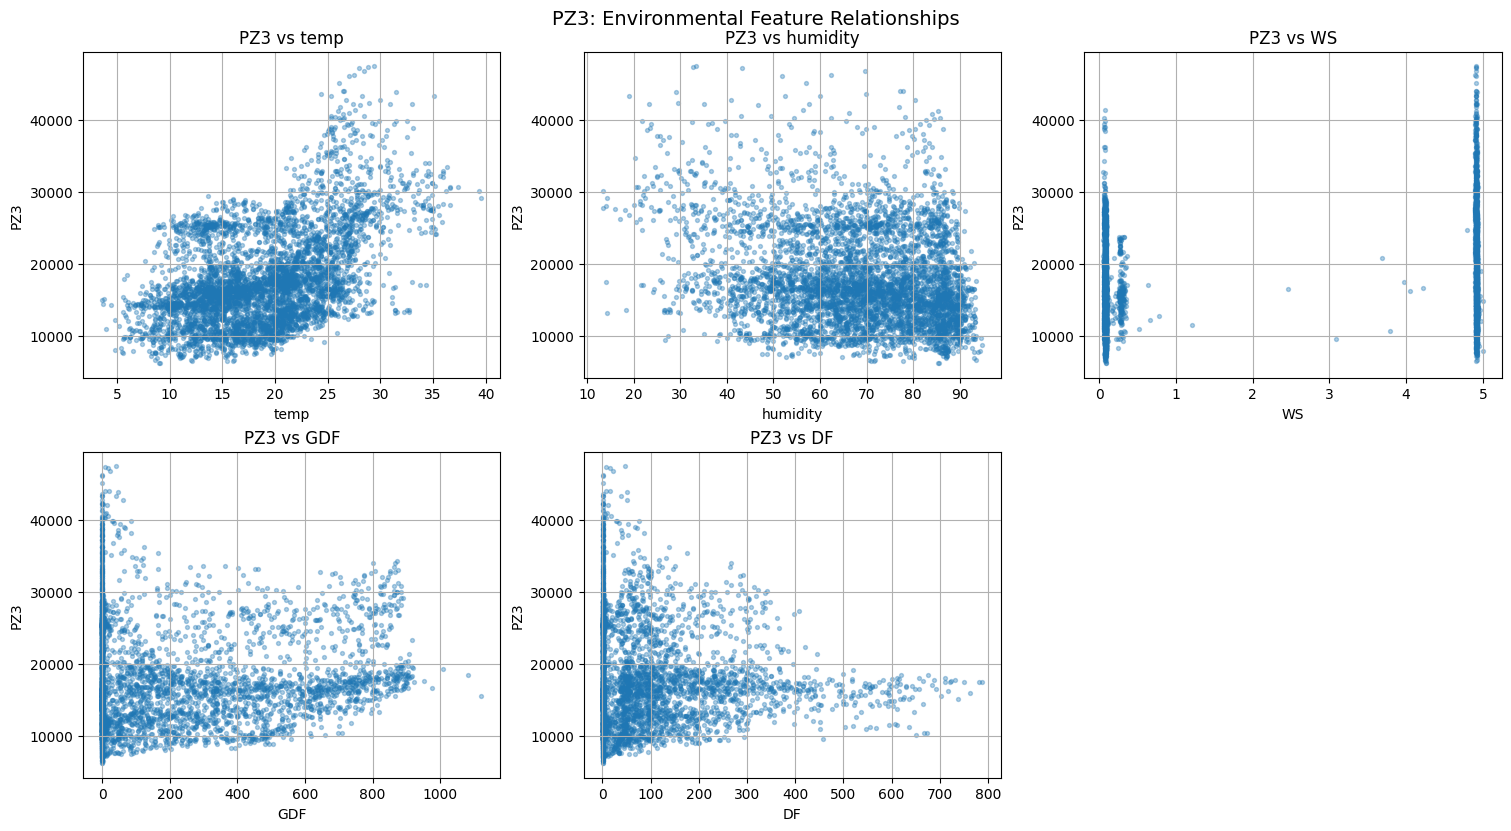

In [12]:
env_cols = ["temp", "humidity", "WS", "GDF", "DF"]

# Sample for scatter plots (optional, keeps plots lighter if dataset is huge)
sample = df.sample(min(5000, len(df)), random_state=42) if len(df) > 5000 else df

for z in zone_cols:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)
    ax_flat = axes.ravel()

    # Only loop through as many axes as we have env features
    for i, e in enumerate(env_cols):
        ax = ax_flat[i]
        ax.scatter(sample[e], sample[z], s=8, alpha=0.35)
        ax.set_title(f"{z} vs {e}")
        ax.set_xlabel(e)
        ax.set_ylabel(z)

    # Hide any unused subplot spaces if fewer than 6 features
    for j in range(len(env_cols), len(ax_flat)):
        fig.delaxes(ax_flat[j])

    fig.suptitle(f"{z}: Environmental Feature Relationships", y=1.02, fontsize=14)
    plt.show()

## Lag Analysis

In [ ]:
'''
from itertools import product

lags_to_try = [1, 2, 3, 6, 12, 24]
for z, e in product(zone_cols, env_cols):
    for k in lags_to_try:
        temp_df = pd.DataFrame({
            e: df[e].shift(k),
            z: df[z]
        }).dropna()
        if len(temp_df) > 100:
            plt.scatter(temp_df[e], temp_df[z], s=8, alpha=0.3)
            plt.title(f"{z} vs {e} (lag={k})")
            plt.xlabel(f"{e} (t-{k})")
            plt.ylabel(f"{z} (t)")
            plt.show()
'''

'\n# === 4) Lag analysis ===\nfrom itertools import product\n\nlags_to_try = [1, 2, 3, 6, 12, 24]\nfor z, e in product(zone_cols, env_cols):\n    for k in lags_to_try:\n        temp_df = pd.DataFrame({\n            e: df[e].shift(k),\n            z: df[z]\n        }).dropna()\n        if len(temp_df) > 100:\n            plt.scatter(temp_df[e], temp_df[z], s=8, alpha=0.3)\n            plt.title(f"{z} vs {e} (lag={k})")\n            plt.xlabel(f"{e} (t-{k})")\n            plt.ylabel(f"{z} (t)")\n            plt.show()\n'

## Autocorrelation & Seasonality

In [9]:
'''
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

for z in zone_cols:
    series = df[z].dropna()
    plot_acf(series, lags=60)
    plt.title(f"ACF - {z}")
    plt.show()

    plot_pacf(series, lags=60, method="ywm")
    plt.title(f"PACF - {z}")
    plt.show()

    try:
        res = seasonal_decompose(
            df.set_index("datetime")[z], period=24
        )  # adjust period as needed
        res.plot()
        plt.suptitle(f"Seasonal Decomposition - {z}", y=1.02)
        plt.show()
    except Exception as e:
        print(f"Decomposition failed for {z}: {e}")
'''

'\nfrom statsmodels.graphics.tsaplots import plot_acf, plot_pacf\nfrom statsmodels.tsa.seasonal import seasonal_decompose\n\nfor z in zone_cols:\n    series = df[z].dropna()\n    plot_acf(series, lags=60)\n    plt.title(f"ACF - {z}")\n    plt.show()\n\n    plot_pacf(series, lags=60, method="ywm")\n    plt.title(f"PACF - {z}")\n    plt.show()\n\n    try:\n        res = seasonal_decompose(\n            df.set_index("datetime")[z], period=24\n        )  # adjust period as needed\n        res.plot()\n        plt.suptitle(f"Seasonal Decomposition - {z}", y=1.02)\n        plt.show()\n    except Exception as e:\n        print(f"Decomposition failed for {z}: {e}")\n'

## Feature-target alignment

In [10]:
'''
alignment_summary = []
for z in zone_cols:
    y = df[z].dropna()
    for e in env_cols:
        best_corr = 0
        best_lag = 0
        for k in range(0, 96):  # up to 4 days if hourly
            c = pd.concat([y, df[e].shift(k)], axis=1).dropna()
            if len(c) > 100:
                corr = c.corr().iloc[0, 1]
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = k
        alignment_summary.append({
            "zone": z, "feature": e, "best_lag": best_lag, "corr": best_corr
        })

alignment_df = pd.DataFrame(alignment_summary)
print("Top feature-target alignments:")
print(
    alignment_df.sort_values(["zone", "corr"], ascending=[True, False])
              .groupby("zone").head(5)
)
'''

'\nalignment_summary = []\nfor z in zone_cols:\n    y = df[z].dropna()\n    for e in env_cols:\n        best_corr = 0\n        best_lag = 0\n        for k in range(0, 96):  # up to 4 days if hourly\n            c = pd.concat([y, df[e].shift(k)], axis=1).dropna()\n            if len(c) > 100:\n                corr = c.corr().iloc[0, 1]\n                if abs(corr) > abs(best_corr):\n                    best_corr = corr\n                    best_lag = k\n        alignment_summary.append({\n            "zone": z, "feature": e, "best_lag": best_lag, "corr": best_corr\n        })\n\nalignment_df = pd.DataFrame(alignment_summary)\nprint("Top feature-target alignments:")\nprint(\n    alignment_df.sort_values(["zone", "corr"], ascending=[True, False])\n              .groupby("zone").head(5)\n)\n'